# Route Classification

This notebook should be run after .pickle files have been generated for each route from the Mask RCNN model in mask_rcnn.ipynb.

### Helper functions for plotting and showing image results

In [1]:
import json
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def plot_image(img,cvt=True,figsize=(25,25)):
    plt.figure(figsize=figsize)
    if cvt:
        if len(img.shape) == 2:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img)
        
def show_image(img,cvt=True):
    if cvt:
        if len(img.shape) == 2:
            cv2.imshow('img',img)
        else:
            cv2.imshow('img',cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
         cv2.imshow('img',img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()       
    
        
def resize_image(image, width=750, inter=cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))

    return cv2.resize(image, dim, interpolation=inter)
        


## Hole detection on indoor climbing walls

Indoor climbing walls have holes (also referred to as dots in the code) with specially formed t-nuts which allow holds to be screwed into the wall. An array of holes typically has a distance of ~15cm between each hole. This is useful information as I'm using hold area as a feature for my neural network - but the equivalent of this in my dataset is the pixel area of the hold. It is clear that taking images from different distances from the wall effectively increases/decreases the pixel area, so having the ability to scale the pixel area of the holds based on the pixel distance between detected dots is useful for data standardisation. The relationship between cm and pixels is known as 'scaling value' in this project.

#### Method

An adaptive threshold is applied to retrieve a binary image, then the detection of blobs can be done through connected component analysis. After lots of testing, I found the following constraints to be suitable for detection of holes on the climbing wall:

- Total area of ~80 pixels
- Ratio between length and width of bounding rectangle on blobs is square-like (here I chose over 0.75)
- Main colour is black (achieved through K-means clustering)

1. Retrieve all detected blobs from connected component analysis
2. Discard any blobs that do not satisfy the constraints as outlined above
3. Return the centres for each detected blob

In [3]:
import rgb_processing

def ratio(n1, n2):
  """Calculates similarity score between 2 numbers
  Args:
      n1 (int): first number
      n2 (int): second number
  Returns:
      (float): similarity score between the 2 numbers
  """
  return 1 - abs(n1 - n2) / (n1 + n2)

def subimage_from_coords(img_src,x1,y1,x2,y2):
    """Retrieve the a slice of an image based on 2 coordinates
    Args:
        img_src (np.ndarray): the image source
        x1,y1,x2,y2: x,y values of coordinate 1 and coordinate 2 respectively
    Returns:
        (np.ndarray) slice of image
    """  
    return img_src[y1:y2,x1:x2]

def percentage_dark(img_src,threshold):
    """Retrieve percentage of 'dark' pixels of an image given a threshold
    Args:
        img_src (np.ndarray): the image source in grayscale
        threshold (int): grayscale threshold value
    Returns:
        (int) percentage of 'dark' pixels of an image given a threshold
    """  
    num_dark = np.sum(img_src < threshold)
    num_light =  np.sum(img_src >= threshold)
    return num_dark/(num_light+num_dark)

def find_dots(img_src):
    """Climbing hole detection using connected component analysis
    Args:
        img_src (Mat): the image source
    Returns:
        dot_centres (list of int tuples): list of rounded (x,y) coordinates of the climbing dots
    """    
    # Create grayscale image
    gray_img = cv2.cvtColor(img_src, cv2.COLOR_BGR2GRAY)

    # Threshold search area
    binary_img = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY_INV, 131, 15)
    
    # Blob detection
    _, _, boxes, _ = cv2.connectedComponentsWithStats(binary_img)
    
    # Ignore the first box as this is the background
    boxes = boxes[1:]

    # Threshold blobs by pixel area and percentage of dark pixels
    filtered_boxes = []
    area_thres_lb = 80
    while True:
        for x,y,w,h,pixels in boxes:
            area_limit = (area_thres_lb < pixels < area_thres_lb+200)
            subimage = subimage_from_coords(gray_img,x,y,x+w,y+h)

            # Thresholding by percentage of dark pixels and main colour distribution
            p = percentage_dark(subimage,120)
            p_limit = 0.4 < p < 1
            if p_limit and area_limit and ratio(w,h) > 0.75:
                # Perform K-means clustering to ensure that the main colour is black
                colour = rgb_processing.get_main_colour(subimage)
                if colour == 'black':
                    filtered_boxes.append((x,y,w,h))                 
        
        # If we've got enough detections break out of the loop, otherwise iteratively decrease the lower area threshold
        # to deal with images taken from a further distance (and hence the holes would be smaller)
        if len(filtered_boxes) > 15:
            break
        else:
            area_thres_lb -= 20
            filtered_boxes = []
            
        if area_thres_lb < 0:
            raise Exception("No dots can be detected in this image!")

    # Create list of dot centres
    dot_centres = []
    img_out = img_src.copy()
    for x,y,w,h in filtered_boxes:
        cv2.rectangle(img_out, (x,y), (x+w,y+h), (0,0,255),2) # draw rectangle around all the detected dots
        dot_centre = (round(x+(w/2)),round(y+(h/2)))
        dot_centres.append(dot_centre)

    return dot_centres, img_out

Detected 108 hole-like features


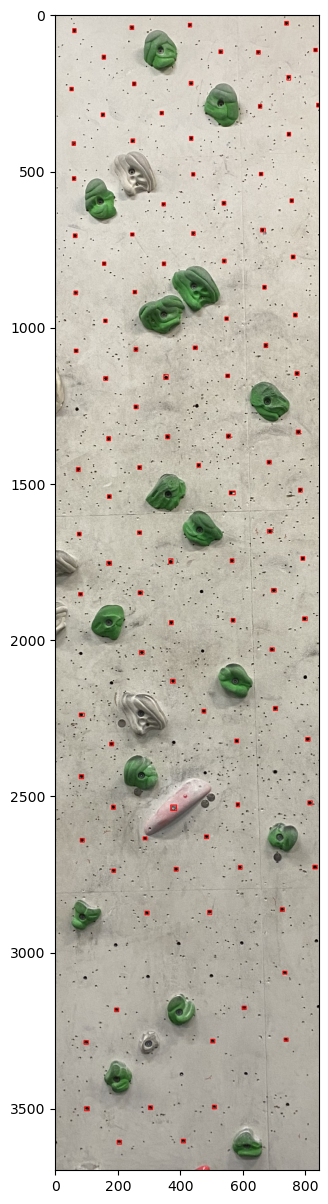

In [4]:
# Demonstration of hole detection

img_src = cv2.imread('route_images/green_VB (7).jpg')
dot_centres, img_out = find_dots(img_src)
print(f'Detected {len(dot_centres)} hole-like features')
plot_image(img_out,figsize=(15,15))

### Calculating the pixel distance between holes and retrieving a scaling value

#### Problems
Once a sufficient number of holes have been detected, the pixel distance can be retrieved. However, calculating this value precisely is a difficult task. Scaling the hold area based on the pixel distance is thus an even harder task considering the following issues:

- There is a lot of variation in the pixel distance between each hole as images can be taken from different angles
- Some images are climbing routes taken from different climbing centres, the distance between holes in cm in real life could be different for each climbing centre
- The pattern of holes can be different e.g. lattice-like or grid-like (see the image on the execution of the code cell below as an example of a grid-like pattern)

Therefore, it's obvious that the scaling value will not be 100% precise or accurate, but it's better than nothing at all as it serves as a decent approximation of relative scaling. The scaling value will be based on the assumption that there is a 15cm difference between each hole on the climbing wall for both lattice-like and grid-like patterns.

#### Proposed Method
1. Calculate the pixel distance between each hole (h1) and its closest hole (h2)

2. Store these distances into a dict where the keys are the rounded distances to the nearest 10 (so that we may collect the modal distance) e.g. a pixel distance of 188.3 would be rounded to 190 and stored in the '190' bin. This discards major outliers.

3. The average pixel distance is the mean of the most frequent rounded distances

4. The scaling value is 15/average_pixel_distance

cm/pixel: 0.08924987811778805
The blue line is just a visual demonstration of the mean distance between detected dots


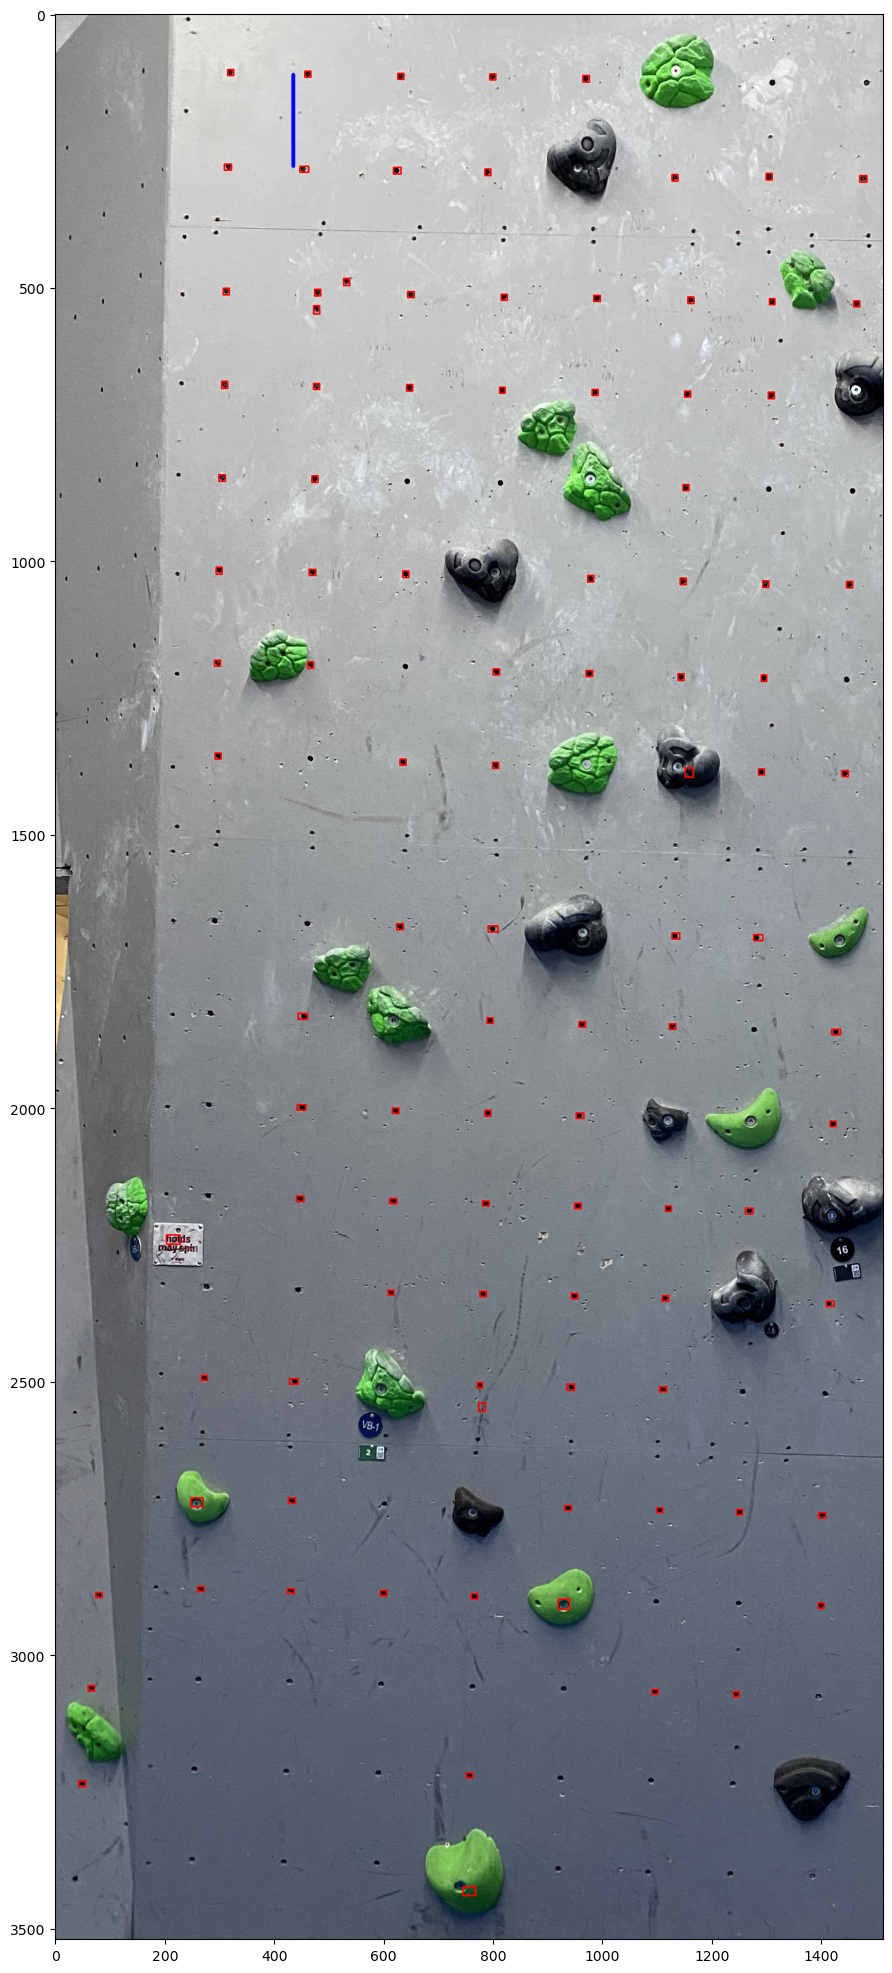

In [5]:
from scipy import spatial
from statistics import mode
from collections import defaultdict

def mean_distance(dot_centres,ignore_exceptions=False):
    """Returns the mean distance between a list of (x,y) coordinates in the vertical or horizontal direction
    Args:
        dot_centres (list): list of (x,y) coordinates of the climbing dots
    Returns:
        avg (int): the mean distance
    """
    # Stores bins of distance values rounded to the nearest 10
    modal_distance_map = defaultdict(list)
    distances = []
    for dot_centre in dot_centres:
        # Create list of coordinates that excludes the current iterated coordinate
        other_centres = dot_centres
        other_centres.remove(dot_centre)
        # Kd-tree for quick nearest-neighbor lookup
        tree = spatial.KDTree(other_centres)
        # Append shortest distance to list of distances
        dist, idx = tree.query(dot_centre)
        rounded_dist = round(dist,-1)
        modal_distance_map[rounded_dist].append(dist)
    
    modal_distance = max(modal_distance_map, key=lambda key: len(modal_distance_map[key]))
    dists = modal_distance_map[modal_distance]
    
    mean_dist = np.mean(dists)
    scale = 15/mean_dist
    
    if scale > 0.2:
        if not ignore_exceptions:
            raise Exception(f"The scale value {scale} is too large, the dot detection is likely to be broken. ")
        else:
            print(f"The scale value {scale} is too large, the dot detection is likely to be broken. ")
        scale = 0.09
    return mean_dist, scale

img_src = cv2.imread('route_images/green_VB (4).jpg')
dot_centres, img_out = find_dots(img_src)
dist,_ = mean_distance(dot_centres)

dot_coord = (435,110)
cv2.line(img_out, dot_coord, (dot_coord[0],dot_coord[1]+round(dist)), (255,0,0), 5)
plot_image(img_out)
print(f"cm/pixel: {15/dist}")
print("The blue line is just a visual demonstration of the mean distance between detected dots")
    

## Route detection (discarding irrelevant holds to the route)

The Mask-RCNN model used to detect holds on a climbing wall detects holds regardless of the colour of the hold. A climbing route will consist of holds that are of the same colour to indicate what holds are relevant to the route. Therefore, a filtration of the irrelevant holds must occur such that any hold that isn't of the colour of the route should be discarded from the route. Sometimes detections from the Mask-RCNN overlap each other due to it detecting the same hold as multiple types of holds. A non-maxima suppression is applied to retrieve only one detection based on the highest confidence value of the n detections on the hold.

#### Method (expained more in the thesis)
1. Retrieve the intended colour of the route from the image name
2. Get the mean colour of each hold using K-means clustering
3. Classify each hold as 'black' or 'white' based on the clustered RGB values or a colour based on the hue values
4. Return a list of indices of the holds where the colour is equal to the intended colour

blue_V1-V3 (19)
Number of detected holds relevant to route: 12


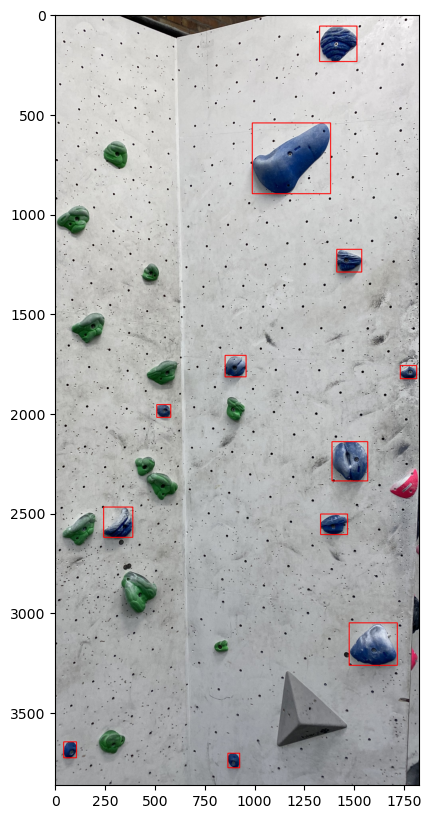

In [6]:
import rgb_processing
import pickle

classes = np.array(['jug','easy_foothold','sloper','large_sloper','easy_edge','crimp_edge','edge_large_sloper','crimp','double_sided_jug','pinch_sloper','foothold','double_sided_sloper','curve_edge_sloper','edge','pocket','pinch','edge_sloper','volume','large_moon_edge','platform','u_edge'])

def cut_from_contour(img, contour):
    """Cut out a section of the provided image given a contour such that the 'background' is completely black
    Args:
        img (np.ndarray): image source
        contour (array): points representing the contour
    Returns:
        (np.ndarray): the extracted object onto a black background
    """
    mask = np.zeros(img.shape, np.uint8) # Create mask
    cv2.drawContours(mask, contour, -1, (255,255,255), -1)
    extracted_hold = np.zeros(img.shape, np.uint8) # Extract the object and place into output image
    extracted_hold[mask > 0] = img[mask > 0]   
    return extracted_hold

def load_data_from_pickle(file_name):
    """Retrieve detection data from the Mask RCNN model from the pickle files
    Args:
        file_name (string): file name without the .jpg extension
    Returns:
        data (dict): detection data from the Mask RCNN model
    """
    if ".jpg" in file_name:
        file_name = file_name.split(".")[0]
    
    with open(f'tensor_data/{file_name}.pickle', 'rb') as handle:
        data = pickle.load(handle)
    return data

def filter_route(file_name,colour=""):
    """Retrieve indices of the holds relevant to the route
    Args:
        file_name (string): file name without the .jpg extension
        colour (string): colour override
    Returns:
        data (dict): detection data from the Mask RCNN model
    """
    if ".jpg" in file_name:
        file_name = file_name.split(".")[0]

    # Load hold data from the file
    data = load_data_from_pickle(file_name)
    
    # Load image file
    img = cv2.imread(f'route_images/{file_name}.jpg')
    
    # Retrieve required colour
    if not colour:
        expected_colour = file_name.split("_")[0]
    else:
        expected_colour = colour

    # For debugging
    # img_detections = img.copy()
    # print(len(data["contours"]))
    
    # Retrieve indices of all holds that are relevant to the route by its colour
    route_indices = []
    for idx, bb in enumerate(data['pred_boxes']):
        
        contour = data['contours'][idx]
        r_bb = np.round(bb).astype('int')
       
        # Cut out hold
        extracted_hold = cut_from_contour(img,contour)
        
        # Retrieve colour of hold
        hold_img = subimage_from_coords(extracted_hold,r_bb[0],r_bb[1],r_bb[2],r_bb[3])
        hold_colour = rgb_processing.get_main_colour(hold_img)
        
        # print(hold_colour)
        
        if expected_colour in hold_colour:
            route_indices.append(idx)
    
    if not route_indices:
        raise Exception(f'Unable to detect any holds')
    
    # Filter out overlapping bounding boxes using non maximal suppression
    boxes = [data['pred_boxes'][i] for i in route_indices]
    confidences = [float(data['scores'][i]) for i in route_indices]
    NMS_indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.7)
    route_indices = [route_indices[i] for i in NMS_indices]
        
    # For debugging
    #show_image(resize_image(img_detections,300),cvt=False)
    return data, route_indices

file_name = "blue_V1-V3 (19)"
img = cv2.imread(f'route_images/{file_name}.jpg')
data, hold_ids = filter_route(file_name)
print(file_name)
print(f'Number of detected holds relevant to route: {len(hold_ids)}')
for i in hold_ids:
    r_bb = np.round(data['pred_boxes'][i]).astype('int')
    cv2.rectangle(img, (r_bb[0],r_bb[1]), (r_bb[2],r_bb[3]), (0,0,255),4)
plot_image(img,figsize=(10,10))

## Route sequencing and distance+direction

The order of the hold sequence matters, my thesis proposes that there must be a relationship between the sequence of holds and the difficulty of the route. In my thesis, caring about how exactly a human would traverse the route is not important so a more basic approach is applied to sequence the route. The approach is to label the holds based on their positional y such that the lowest y valued hold is the first hold in the sequence and the highest y valued hold is the last hold in the sequence. Along the way, the distance and direction between hold i and the next hold in the sequence (hold i+1) and these two new features will be used in the classifer.

#### Problems:
- It is obvious that this sequencing approach does not work for routes that operate horizontally (but rarely any indoor climbing routes are sequenced in this way there are no examples of these routes in my dataset).

#### Method
1. Create a 'route sequence' such that the sequence is a sorting of the holds by their positional y value from lowest to highest
2. Calculate the scaled distance and direction between each hold in the sequence and store it into a dictionary mapping

Scale: 0.09368089424463563
Route: [9, 7, 16, 17, 13, 1, 12, 4, 6, 5, 15, 10, 14, 3, 8, 11, 2, 0]
Distance Map: 
{9: 47.10388642848603, 7: 49.74526053301458, 16: 43.82353782976538, 17: 51.27426723567535, 13: 57.89221560330185, 1: 39.04527068982733, 12: 46.93674577293971, 4: 97.70935233437093, 6: 46.24649169348808, 5: 32.55057225054391, 15: 43.83344958820351, 10: 67.07656698489443, 14: 20.606602819489044, 3: 38.04528635024392, 8: 54.53950085065145, 11: 41.52547635757014, 2: 41.478108557009875, 0: 0}
Direction Map: 
{9: 161.92539724046523, 7: 29.316609678649638, 16: 63.05152198789604, 17: 151.2809307916719, 13: 17.613980535398227, 1: 161.39116467145112, 12: 173.69769393041545, 4: 12.570516359915553, 6: 173.0189425931702, 5: 112.50570481227874, 15: 141.0724564072077, 10: 0.3200848237816687, 14: 133.71060209593975, 3: 58.69750547491191, 8: 169.80958649225565, 11: 37.85231021361413, 2: 133.71883830535793, 0: 0}


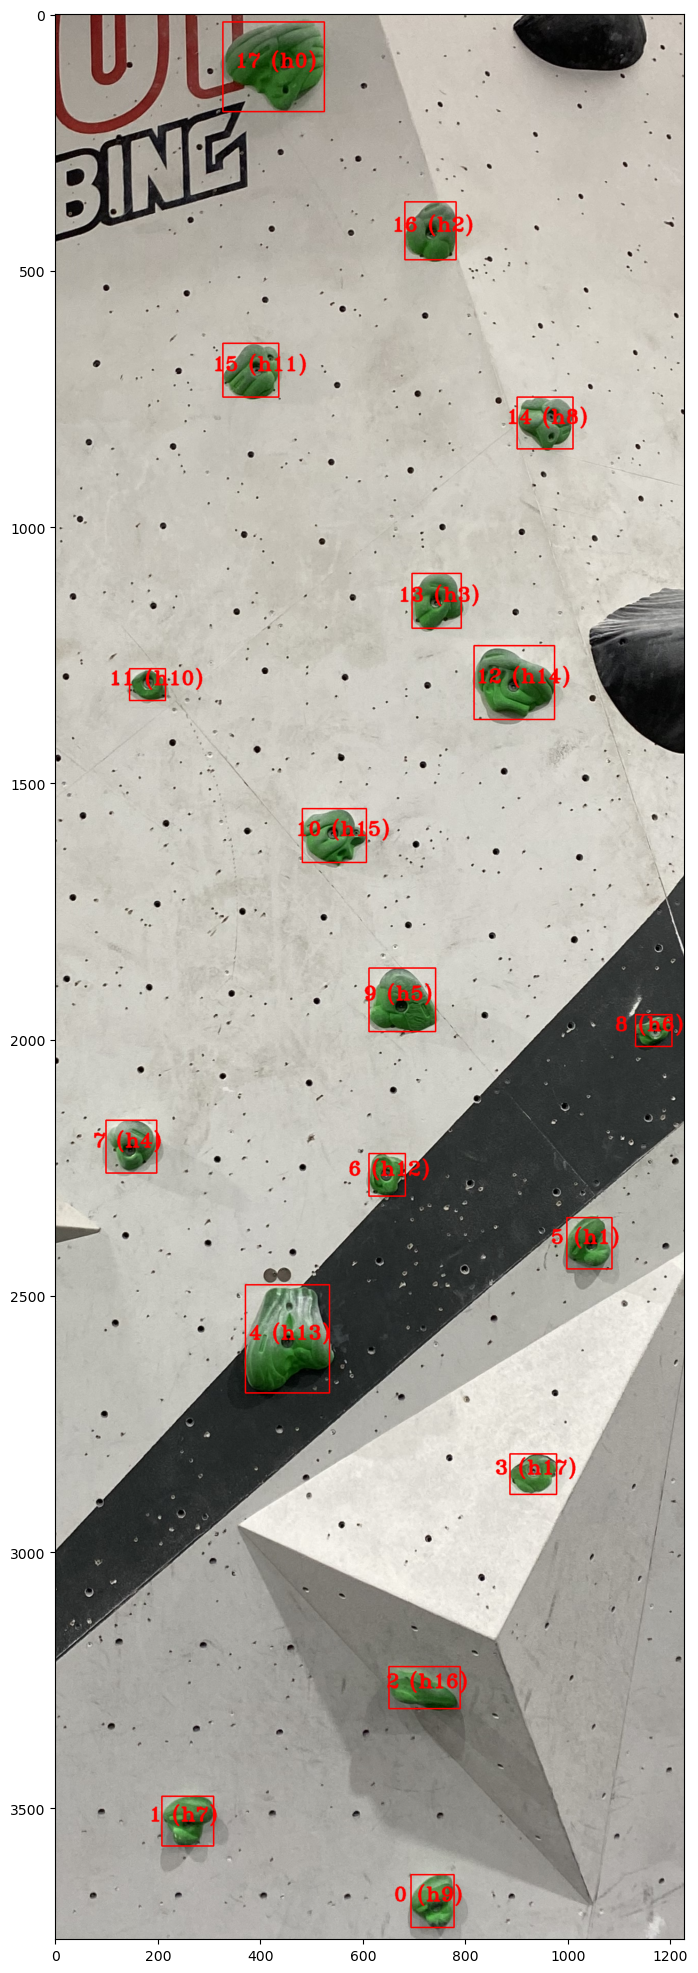

In [7]:
from math import hypot, atan2, degrees

def centres_from_boxes(bounding_boxes):
    """Returns a list of centre coordinates given a list of bounding boxes
    Args:
        bounding_boxes (list): list of bounding boxes
    Returns:
        centres (list): list of centre coordinates for each bounding box
    """
    centres = [((bb[0]+bb[2])/2,(bb[1]+bb[3])/2) for bb in bounding_boxes]
    return np.round(centres).astype('int')

def get_route(hold_ids,hold_centres):
    """Returns a list of holds and their centres sorted by their positional y from lowest to highest
    Args:
        hold_ids (list): indices of each hold
        hold_centres (list): centre coordinates of each hold
    Returns:
        sorted_ids (list): sorted indices of each hold
        sorted_centres (list): sorted centre coordinates of each hold
    """
    z = zip(hold_ids,hold_centres)
    zs = sorted(z, key = lambda x: x[1][1],reverse=True)
    sorted_ids, sorted_centres = map(list, zip(*zs))
    return sorted_ids, sorted_centres

def get_distance_direction(route,route_centres,scale):
    distance_map = dict()   
    direction_map = dict()
    
    # Calculate distance and direction between hold i and hold i+1
    for i, hold_id in enumerate(route):
        c1 = route_centres[i]
        if i < len(route)-1:
            c2 = route_centres[i+1]
            distance_map[hold_id] = hypot(c2[0] - c1[0], c2[1] - c1[1]) * scale
            direction_map[hold_id] = abs(degrees(atan2(c2[1] - c1[1], c2[0] - c1[0])))
        else:
            # The last hold is the end of the sequence so there's no distance or direction to be calculated
            distance_map[hold_id] = 0
            direction_map[hold_id] = 0
            
    return distance_map, direction_map
        
        
file_name = "green_VB (32)"
img = cv2.imread(f'route_images/{file_name}.jpg')

# Find dot centres to scale distances
dot_centres, _ = find_dots(img)
dot_dist, scale = mean_distance(dot_centres)
print(f"Scale: {scale}")

# Retrieve only the holds that are relevant to the route
data, hold_ids = filter_route(file_name)

# Create centre coordinates for each hold
bounding_boxes = [data['pred_boxes'][hold_id] for hold_id in hold_ids]
hold_centres = centres_from_boxes(bounding_boxes)

# Create mapping from hold id to its centre
id_to_centre = dict()
for i,hold_id in enumerate(hold_ids):
    id_to_centre[hold_id] = hold_centres[i]
    
# Create a route as a sequence of holds sorted by y
route, route_centres = get_route(hold_ids,hold_centres)
print(f"Route: {route}")

# Create a dict mapping from hold_id to its distance and direction to the next hold in the route sequence
distance_map, direction_map = get_distance_direction(route,route_centres,scale)

print(f'Distance Map: \n{distance_map}')
print(f'Direction Map: \n{direction_map}')

# Show the route
temp = img.copy()
for i,hold_id in enumerate(route):
    text = f"{str(i)} (h{hold_id})"
    coords = id_to_centre[hold_id]
    coords[0] -= 75
    bb = np.round(data['pred_boxes'][hold_id]).astype('int')
    cv2.putText(temp, text, coords, cv2.FONT_HERSHEY_TRIPLEX , 1.25, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.rectangle(temp, (bb[0],bb[1]), (bb[2],bb[3]), (0, 0, 255), 2)

# Note that the number in brackets is the hold id, the number not in brackets is the hold is its position in the sequence
plot_image(temp)



## Preparing the dataset

Now combine all of the methods described above to create a dataset to be used for the RNN classifier.

In [ ]:
import glob
import os
import random

def check_num_samples(path):
    """Prints the number of image samples for each route class
    Args:
        path (str): path to the images folder
    """
    class_count = defaultdict(int)
    for file_path in glob.glob(path):
        for cls in ['VB','V0-V2','V1-V3','V2-V4','V3-V5','V5-V7','V7-V8']:
            if cls in file_path:
                class_count[cls] += 1
    print(class_count)
    
def get_route_images(path, route_classes, num_per_cls=0):
    """Returns a dictionary mapping from route class to a list of image files that are in that route class
    Args:
        path (str): path to the images folder
        classes (list): list of route classes
        num_per_cls (int): number of samples per class
    Returns:
        (dict) from route class to a list of image files that are in that route class
    """    
    route_files_by_class = defaultdict(list)
    
    # Binary classification between 'Easy' routes and 'Other' routes
    if len(route_classes)==2 and 'Easy' in route_classes and 'Other' in route_classes:
        for file_path in glob.glob(path):
            file_name = os.path.basename(file_path)
            if 'VB' in file_path or 'V0-V2' in file_path:
                route_files_by_class['Easy'].append(file_name)
            else:
                route_files_by_class['Other'].append(file_name)
    # Multi-class classification
    else:
        for file_path in glob.glob(path):
            for cls in route_classes:
                if cls in file_path:
                    file_name = os.path.basename(file_path)
                    route_files_by_class[cls].append(file_name)
                    
    if num_per_cls != 0:
        for cls in route_classes:
            random.shuffle(route_files_by_class[cls])
            route_files_by_class[cls] = route_files_by_class[cls][0:num_per_cls]
            if len(route_files_by_class[cls]) != num_per_cls:
                raise Exception(f"The class {cls} does not have {num_per_cls} images in the dataset.")
    
    return route_files_by_class

def approximate_area_from_bb(bb):
    """Approximate the area of the hold from a bounding box. Useful when the retrieved contour area for a hold is 0.
    Args:
        bb (array): coordinates for the bounding box
    Returns:
        (float): approximated area
    """   
    x_len = bb[2]-bb[0]
    y_len = bb[3]-bb[1]
    return 0.5 * (x_len*y_len)

# For debugging purposes
def generate_datum(file_name):
    print(f'Processing {file_name}')

    # Find dot centres to define scale
    img = cv2.imread(f'route_images/{file_name}')
    dot_centres, _ = find_dots(img)
    scale = 15/modal_distance(dot_centres)

    # Retrieve only the holds that are relevant to the route
    data, hold_ids = filter_route(os.path.basename(file_name).split(".")[0])

    # Create centre coordinates for each hold
    bounding_boxes = [data['pred_boxes'][hold_id] for hold_id in hold_ids]
    hold_centres = centres_from_boxes(bounding_boxes)

    # Create mapping from hold id to its centre
    id_to_centre = dict()
    for i,hold_id in enumerate(hold_ids):
        id_to_centre[hold_id] = hold_centres[i]

    # Create a route as a sequence of holds sorted by y
    route, route_centres = get_route(hold_ids,hold_centres)

    # Create a dict mapping from hold_id to its distance and direction to the next hold in the route sequence
    distance_map, direction_map = get_distance_direction(route,route_centres,scale)

    # Create feature data
    feature_data = []
    for hold_id in route:
        cls = data['pred_classes'][hold_id]
        contour_area = data['contour_area'][hold_id]
        area = data['contour_area'][hold_id] * scale
        distance_to_next_hold = distance_map[hold_id]
        direction_to_next_hold = direction_map[hold_id]
        feature_data.append([cls,area,distance_to_next_hold,direction_to_next_hold])    
        
    return(feature_data)
    
def generate_dataset(route_images_by_class,ignore_exceptions=False):
    """Create a dataset from a mapping of route images to their class
    Args:
        route_images_by_class (dict): mapping from class to list of route images
    Returns:
        dataset (list): dataset[i][0] holds information about the route, dataset[i][1] is the class label
    """   
    dataset = []
    for cls in route_images_by_class.keys():
        for file_name in route_images_by_class[cls]:
            print(f'Processing {file_name}')
            
            # Find dot centres to define scale
            img = cv2.imread(f'route_images/{file_name}')
            dot_centres, _ = find_dots(img)
            mean_dist, scale = mean_distance(dot_centres,ignore_exceptions)
            
            # Retrieve only the holds that are relevant to the route
            data, hold_ids = filter_route(os.path.basename(file_name).split(".")[0])

            # Create centre coordinates for each hold
            bounding_boxes = [data['pred_boxes'][hold_id] for hold_id in hold_ids]
            hold_centres = centres_from_boxes(bounding_boxes)

            # Create mapping from hold id to its centre
            id_to_centre = dict()
            for i,hold_id in enumerate(hold_ids):
                id_to_centre[hold_id] = hold_centres[i]

            # Create a route as a sequence of holds sorted by y
            route, route_centres = get_route(hold_ids,hold_centres)

            # Create a dict mapping from hold_id to its distance and direction to the next hold in the route sequence
            distance_map, direction_map = get_distance_direction(route,route_centres,scale)
            
            # Create feature data
            feature_data = []
            for hold_id in route:
                cls = data['pred_classes'][hold_id]
                contour_area = data['contour_area'][hold_id]
                
                # There is a bug where OpenCV can't calculate the contour area and for some binary masks
                # So approximate it from the bounding box
                if contour_area < 1:
                    area = approximate_area_from_bb(data['pred_boxes'][hold_id]) * scale
                else:
                    area = contour_area * scale
                
                distance_to_next_hold = distance_map[hold_id]
                direction_to_next_hold = direction_map[hold_id]
                feature_data.append([cls,area,distance_to_next_hold,direction_to_next_hold])
            
            dataset.append((file_name,feature_data))
    
    print('Finished!')
    return dataset

# datum = generate_datum("black_V2-V4 (4).jpg")
# print(datum)
# print(len(datum))

ROUTE_IMAGES_PATH = ('route_images/*')

binary_route_classes = ['Easy','Other']
multi_route_classes = ['VB','V1-V3','V2-V4','V3-V5','V5-V7','V7-V8']
check_num_samples(ROUTE_IMAGES_PATH)
route_images_by_class = get_route_images(ROUTE_IMAGES_PATH, multi_route_classes)
dataset = generate_dataset(route_images_by_class,True)

In [ ]:
# Optionally cache the dataset
cache = True
if cache:
    with open('dataset_multi_imbalanced.pickle', 'wb') as handle:
        pickle.dump(dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)


## Normalising the dataset

In preparation for a neural network, the data values must be normalised in the range (0-1) to improve the performance and training of the model. Furthermore, each route in the dataset must be padded with zeros so that it has the maximum number of holds in the dataset as the shapes of the input to the model must be the same.

#### Method:
1. Normalise each feature to the range (0,1) 
2. Pad each route with dummy holds (which consist of data values with 0) to standardise the shape of the features.

In [8]:
def normalise_value(v,min_v,max_v):
    return (v - min_v) / (max_v - min_v)

def cls_from_route_label(name,mode='normal'):
    if mode == 'binary':
        if 'VB' in name or 'V0-V2' in name:
            return 0
        else:
            return 1 
    else:
        classes = ['VB','V1-V3','V2-V4','V3-V5','V5-V7','V7-V8']
    for i,cls in enumerate(classes):
        if cls in name:
            return i
    
def normalise_dataset(dataset,num_hold_classes,mode='normal'):
    """Normalise and pad the dataset 
    Args:
        dataset (list): the dataset
        num_hold_classes (list): number of classes for each hold
    Returns:
        normalised_dataset: normalised version of the dataset where each value is in range (0-1)
        normalisation_values: normalisation values
    """   
    cls_labels = [cls_from_route_label(file_name,mode) for file_name,_ in dataset]
    dataset_without_files = [data for _,data in dataset]
    
    contour_areas = []
    distances = []
    directions = []
    hold_counts = []
    
    # Create lists of all contour areas, distances and directions
    for i,route_data in enumerate(dataset_without_files):
        hold_count = 0
        for hold in route_data:
            contour_areas.append(hold[1])
            distances.append(hold[2])
            directions.append(hold[3])
            hold_count +=1
        hold_counts.append(hold_count)
    
    # Retrieve max and min for each feature
    min_area = np.amin(contour_areas)
    max_area = np.amax(contour_areas)
    min_dist = np.amin(distances)
    max_dist = np.amax(distances)
    max_holds = np.amax(hold_counts)
    
    # Normalise the data
    for i, route_data in enumerate(dataset_without_files):
        for j, hold in enumerate(route_data):   
            norm_hold = hold[0] / num_hold_classes
            norm_area = normalise_value(hold[1],min_area,max_area)
            norm_dist = normalise_value(hold[2],min_dist,max_dist)
            norm_dir = normalise_value(hold[3],0,180)
            normalised_data = [norm_hold,norm_area,norm_dist,norm_dir]
            dataset_without_files[i][j] = normalised_data
    
    # Pad any routes until they reach the maximum hold count
    for i in range(len(dataset_without_files)):
        num_holds = len(dataset_without_files[i])
        diff = abs(max_holds-num_holds)
        if diff > 0:
            for d in range(diff):
                dataset_without_files[i].append([0,0,0,0])
    
    normalised_dataset = list(zip(dataset_without_files,cls_labels))
    normalisation_values = [min_area,max_area,min_dist,max_dist,max_holds,num_hold_classes]
    return normalised_dataset, normalisation_values
    

# Load dataset from cache
with open('dataset_multi_imbalanced.pickle', 'rb') as handle:
    dataset = pickle.load(handle)

with open('dataset_binary_imbalanced.pickle', 'rb') as handle:
    dataset_b = pickle.load(handle)

hold_classes = ['jug','easy_foothold','sloper','large_sloper','easy_edge','crimp_edge','edge_large_sloper','crimp','double_sided_jug','pinch_sloper','foothold','double_sided_sloper','curve_edge_sloper','edge','pocket','pinch','edge_sloper','volume','large_moon_edge','platform','u_edge']
normalised_dataset, norm_values = normalise_dataset(dataset,len(hold_classes),mode='normal')
normalised_dataset_b, norm_values_b = normalise_dataset(dataset_b,len(hold_classes),mode='binary')


In [9]:
# normalised_dataset[i] returns ([data],label) for the sample at i
X = np.array([data for data,_ in normalised_dataset])
y = np.array([label for _,label in normalised_dataset])

X_b = np.array([data for data,_ in normalised_dataset_b])
y_b = np.array([label for _,label in normalised_dataset_b])

print("Multi-class sample data")
print(X[5])
print(X.shape)
print(y)
print("\n Binary sample data")
print(X_b[5])
print(X_b.shape)
print(y_b)

Multi-class sample data
[[0.23809524 0.01579819 0.32291894 0.91010903]
 [0.         0.00999585 0.27355836 0.69183439]
 [0.57142857 0.01104016 0.37407641 0.01607295]
 [0.19047619 0.01696521 0.30367536 0.63496338]
 [0.28571429 0.08202254 0.32103236 0.8627498 ]
 [0.04761905 0.0053687  0.3792154  0.21103764]
 [0.0952381  0.02648854 0.35150777 0.89861896]
 [0.80952381 0.02985234 0.35616462 0.21438422]
 [0.80952381 0.02076072 0.04563547 0.70427236]
 [0.19047619 0.0277828  0.27588896 0.81668951]
 [0.         0.02594048 0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
(146, 19, 4)
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

## Build Keras Model

The model I'm proposing is a recurrent neural network with GRU and Bidirectional GRU layers. The intuition behind the use of GRU cells is to preserve information about the previous holds in sequence, but wrapping this into a bidirectional layer means that there is extra information to be learned about the next holds in the route sequence.

I've built a multi-class classification model and a binary classification model. As discussed in my thesis, I don't have enough data for a neural network to learn for a multi-class classification task, but I do have enough for a binary classification task.

In [64]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, GRU, Flatten
from sklearn.model_selection import train_test_split

# Split data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
Xb_train, Xb_test, yb_train, yb_test = train_test_split(X_b, y_b, test_size=0.3)

def create_model(X_train,mode='binary'):
    model = Sequential()
    # Binary Model
    if mode == 'binary':
        model.add(Bidirectional(GRU(32, recurrent_dropout=0.2), input_shape=(X_train.shape[1:])))
        
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))

        model.add(Dense(1, activation='sigmoid'))
    # Multi-class Model
    else:
        model.add(Bidirectional(GRU(32, recurrent_dropout=0.2), input_shape=(X_train.shape[1:])))

        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))
        
        model.add(Dense(6, activation='softmax'))
    return model


def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, mode='binary'):
    if mode == 'binary':
        model.compile(
            loss='binary_crossentropy',
            optimizer=tf.keras.optimizers.Adam(0.001),
            metrics=['accuracy'])
        epochs=250
    else:
        model.compile(
            loss='sparse_categorical_crossentropy',
            optimizer=tf.keras.optimizers.Adam(0.001),
            metrics=['accuracy'],
        )       
        epochs=600
    history = model.fit(X_train,
              y_train,
              epochs=epochs,      
              validation_data=(X_test, y_test),
              verbose=0)

    results = model.evaluate(X_test, y_test)
    return results, history

## Train multi-class classification model

Run this cell only if the intention is to train a multi-class classification model

In [65]:
multi_model = create_model(X_train,mode='multi')
results, history = train_and_evaluate_model(multi_model, X_train, y_train, X_test, y_test, mode='multi')
print("Test accuracy:",results[1])

1/1 [==============================] - 0s 24ms/step - loss: 1.5760 - accuracy: 0.6000
Test accuracy: 0.6000000238418579


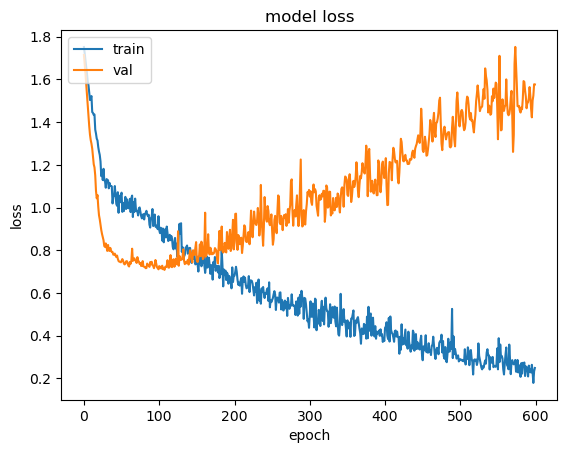

In [66]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Train multi-class classification model using K-fold CV

In [67]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
    
# K-fold cross validation for binary classification
k = 5
skf = StratifiedKFold(n_splits=k,shuffle=True)
total_results = []
route_classes = ['VB','V1-V3','V2-V4','V3-V5','V5-V7','V7-V8']
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    print("Running Fold", i+1, "/", k)
    model = None # Clearing the NN.
    model = create_model(X[train_index],mode='multi')
    results,_ = train_and_evaluate_model(model, X[train_index], y[train_index], X[test_index], y[test_index],mode='multi')
    y_pred = model.predict(X[test_index])
    y_pred_cls = [np.argmax(pred) for pred in y_pred]
    print(y_pred_cls)
    print(y[test_index])
    print(classification_report(y[test_index], y_pred_cls,target_names=route_classes))
    
    total_results.append(results)
    
print(total_results)
accuracies = [res[1] for res in total_results]
print("K-fold Mean test accuracy:",np.mean(accuracies))

Running Fold 1 / 5
1/1 [==============================] - 0s 431ms/step
[0, 4, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3, 2, 2, 5, 3, 3, 4]
[2 2 2 2 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 4 4 5 5]
              precision    recall  f1-score   support

          VB       0.86      0.86      0.86        14
       V1-V3       0.62      1.00      0.77         5
       V2-V4       0.00      0.00      0.00         4
       V3-V5       0.33      0.33      0.33         3
       V5-V7       0.00      0.00      0.00         2
       V7-V8       0.00      0.00      0.00         2

    accuracy                           0.60        30
   macro avg       0.30      0.37      0.33        30
weighted avg       0.54      0.60      0.56        30

Running Fold 2 / 5
1/1 [==============================] - 0s 411ms/step
[4, 2, 4, 0, 1, 1, 0, 2, 1, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 1, 2, 3, 5, 1, 3, 4]
[2 2 2 2 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 4 4 4 5]
            

D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 0s 412ms/step
[4, 2, 5, 3, 2, 4, 3, 1, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 2, 5, 4, 4, 5]
[2 2 2 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 4 4 4 5]
              precision    recall  f1-score   support

          VB       0.92      0.85      0.88        13
       V1-V3       1.00      0.17      0.29         6
       V2-V4       0.25      0.33      0.29         3
       V3-V5       0.40      0.67      0.50         3
       V5-V7       0.50      0.67      0.57         3
       V7-V8       0.33      1.00      0.50         1

    accuracy                           0.62        29
   macro avg       0.57      0.61      0.50        29
weighted avg       0.75      0.62      0.61        29

Running Fold 5 / 5
1/1 [==============================] - 0s 408ms/step
[2, 2, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 2, 4]
[2 2 2 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 4 4 5 5]
              precision    recall  f

D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Train binary classification model

Run this cell only if the intention is to train a binary classification model

In [68]:
binary_model = create_model(X_train,mode='binary')
results, history = train_and_evaluate_model(binary_model, Xb_train, yb_train, Xb_test, yb_test, mode='binary')
print("Test accuracy:",results[1])

2/2 [==============================] - 0s 7ms/step - loss: 0.3235 - accuracy: 0.8913
Test accuracy: 0.8913043737411499


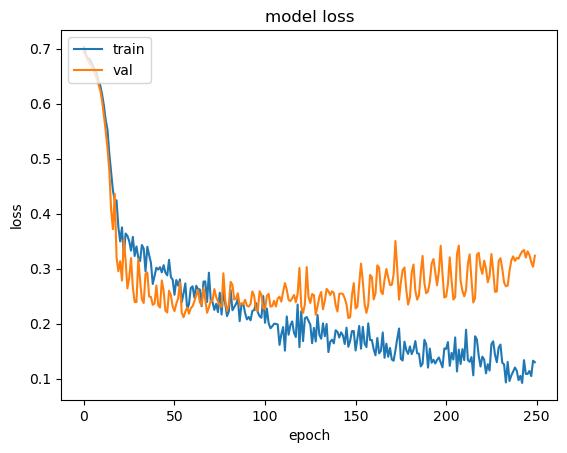

In [69]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Train binary classification model using K-fold CV

In [70]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
    
# K-fold cross validation for binary classification
k = 5
skf = StratifiedKFold(n_splits=k,shuffle=True)
total_results = []
for i, (train_index, test_index) in enumerate(skf.split(X_b, y_b)):
    print("Running Fold", i+1, "/", k)
    model = None # Clearing the NN.
    model = create_model(X_b[train_index],mode='binary')
    results, _ = train_and_evaluate_model(model, X_b[train_index], y_b[train_index], X_b[test_index], y_b[test_index])
    y_pred = model.predict(X_b[test_index])
    y_pred_bool = [round(pred[0]) for pred in y_pred]
    print(classification_report(y_b[test_index], y_pred_bool))
    
    total_results.append(results)
    
print(total_results)
accuracies = [res[1] for res in total_results]
print("K-fold Mean test accuracy:",np.mean(accuracies))

Running Fold 1 / 5
1/1 [==============================] - 0s 407ms/step
              precision    recall  f1-score   support

           0       0.83      0.71      0.77        14
           1       0.79      0.88      0.83        17

    accuracy                           0.81        31
   macro avg       0.81      0.80      0.80        31
weighted avg       0.81      0.81      0.80        31

Running Fold 2 / 5
1/1 [==============================] - 0s 410ms/step
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        14
           1       0.94      0.94      0.94        17

    accuracy                           0.94        31
   macro avg       0.93      0.93      0.93        31
weighted avg       0.94      0.94      0.94        31

Running Fold 3 / 5
1/1 [==============================] - 0s 408ms/step
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        13
           1       0.

## Perform accuracy test

A simple accuracy test is supplied with this notebook, though more detailed evaluation methods will be explored in the thesis.

In [ ]:
def accuracy_test(model,X,y,route_classes,mode=''):
    num_correct = 0
    num_total = X.shape[0]
    for i in range(num_total):
        sample = X[i:i+1]
        prediction = model.predict(sample,verbose = 0)
        if len(route_classes) == 2:
            expected_class = route_classes[y[i]]
            class_prediction = route_classes[round(prediction[0][0])]
        else:
            expected_class = route_classes[y[i]]
            class_prediction = route_classes[np.argmax(prediction)]
        if class_prediction == expected_class:
            num_correct += 1
    print(f'{mode} Accuracy: {(num_correct/num_total)*100}%')    
    
def predict_from_sample(sample_num,model,X,y,route_classes):
    sample = X[sample_num:sample_num+1]
    prediction = model.predict(sample,verbose = 0)
    print(prediction)

    if len(route_classes) == 2:
        expected_class = route_classes[y[sample_num]]
        class_prediction = route_classes[round(prediction[0][0])]
    else:
        expected_class = route_classes[y[sample_num]]
        class_prediction = route_classes[np.argmax(prediction)]

    print(f'Predicted: {class_prediction}, Actual: {expected_class}')


### Run this cell only for the multi-class classification model

In [ ]:
predict_from_sample(1, multi_model, X, y, route_classes)

# Accuracy on test set
accuracy_test(multi_model,X_test,y_test,route_classes,mode='Test')

# Accuracy on train set
accuracy_test(multi_model,X_train,y_train,route_classes,mode='Train')

### Run this cell only for the binary classification model

In [ ]:
route_classes_b = ['Easy','Other']

predict_from_sample(4, binary_model, X_b, y_b, route_classes_b)

# Accuracy on test set
accuracy_test(binary_model,Xb_test,yb_test,route_classes_b,mode='Test')

# Accuracy on train set
accuracy_test(binary_model,Xb_train,yb_train,route_classes_b,mode='Train')